In [2]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


In [16]:
from gridtools.solps_python_scripts.read_b2fgmtry import *

# Hermes IO

In [5]:
casestore = dict()

In [6]:
db = CaseDB()

toload = [
    dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="3e19", id="d11c-d10d_3e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True)
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [4]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [9]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

1e19
2e19


# Read SOLEDGE CSV data

In [28]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Read SOLPS

In [11]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [ ]:
solps = sp["nsep_2e19"].regions["omp"]["rfluxa3da"]

In [9]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



In [51]:
solpscases.keys()

dict_keys(['base', 'noiz_core', 'gammai_2.5', 'dpuff_1e22', 'dpuff_5e21', 'no_fast_reflec', 'nsep_2e19', 'nsep_3e19', 'narrow_core', 'no_visc'])

# Lineplots

In [13]:
plt.close("all")
%matplotlib inline

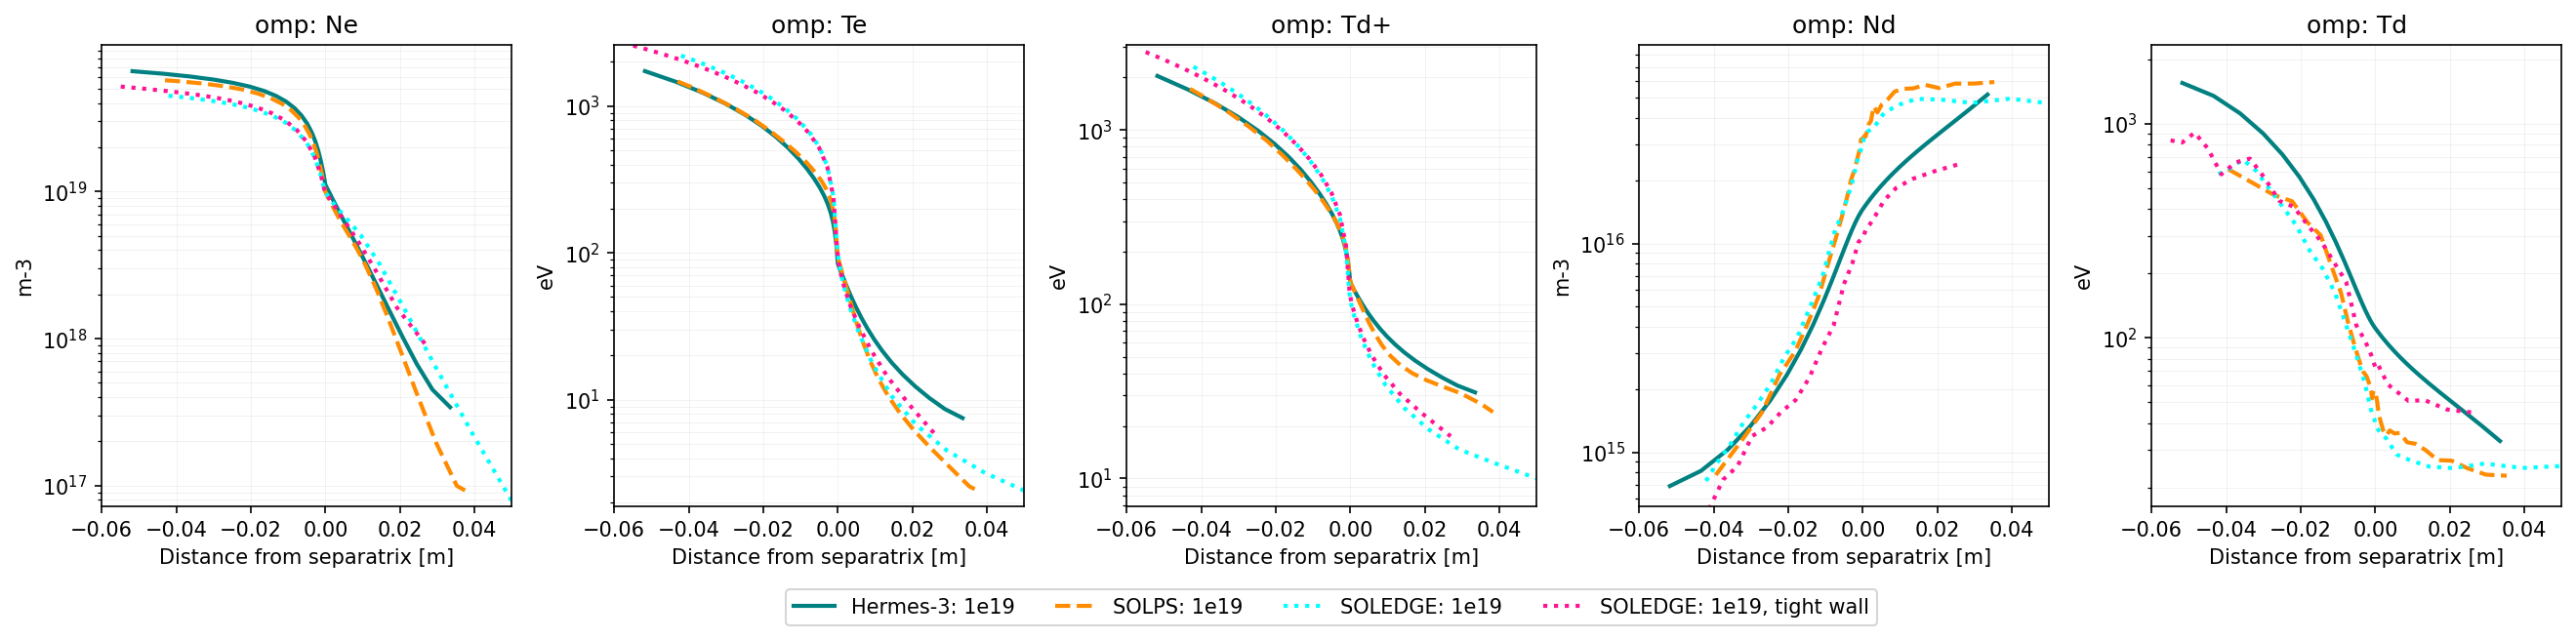

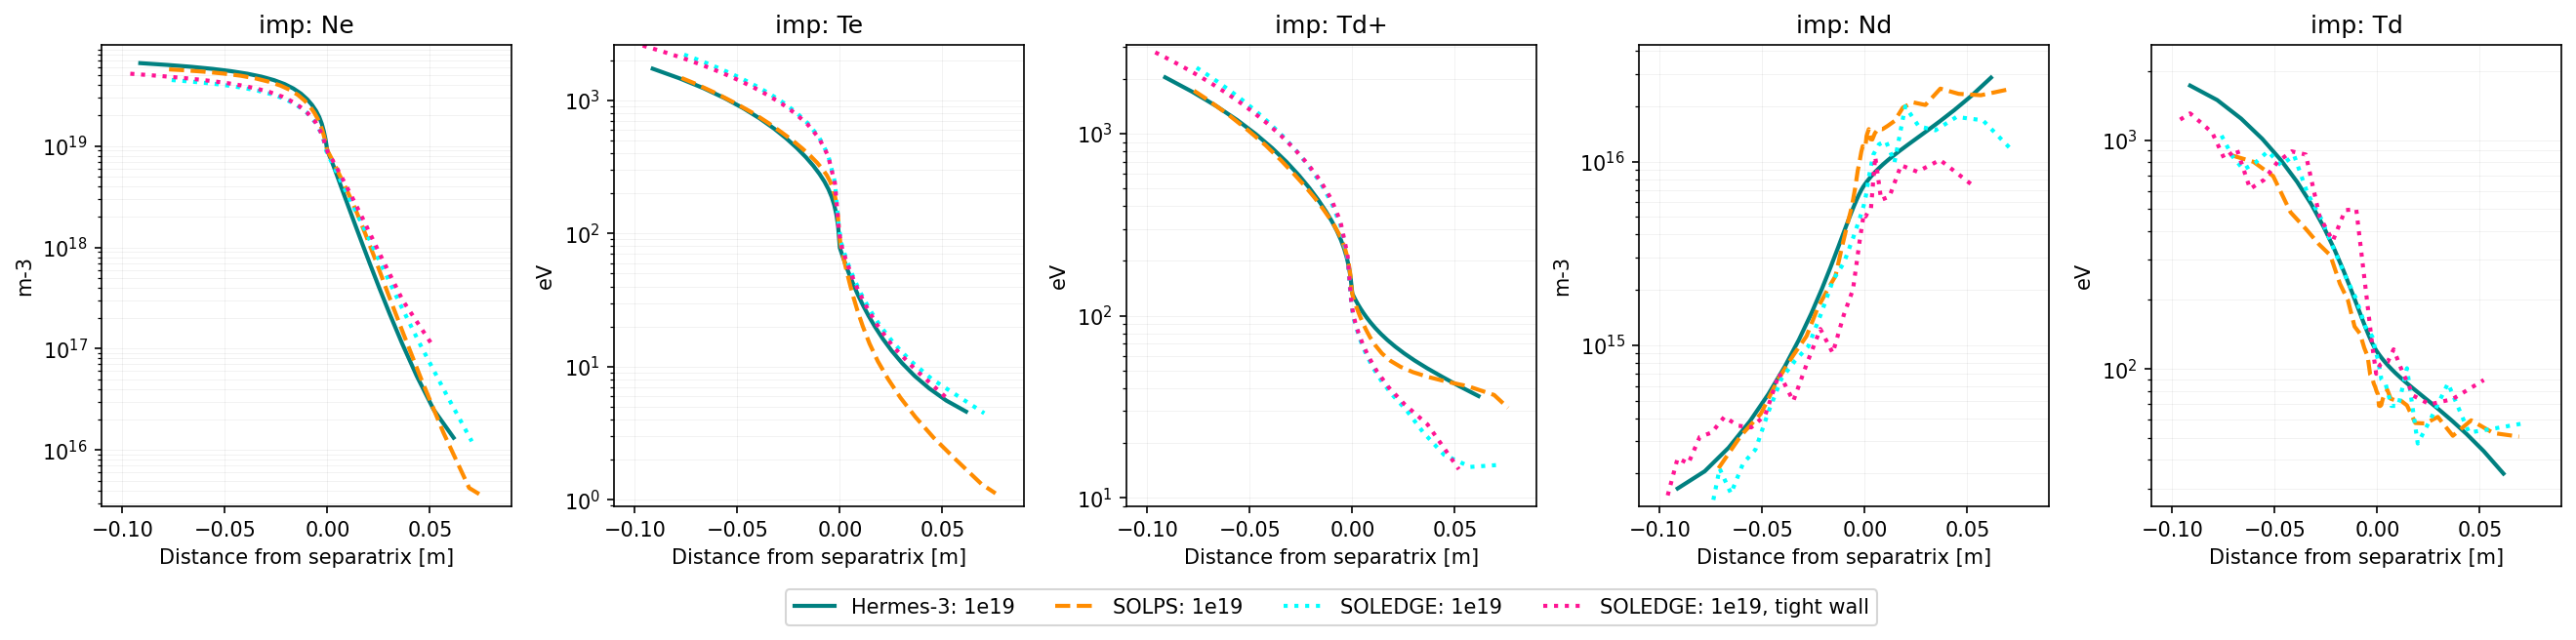

In [34]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    # "Hermes-3: 1e19": dict(data=hr["1e19"], color="#3288bd"),
    # "Hermes-3: 2e19": dict(data=hr["2e19"], color="#fc8d59"),
    # # "Hermes-3: 3e19": dict(data=hr["3e19"], color="#fc8d59"),
    
    # "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    # "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="#fc8d59"),
    
    # "SOLEDGE: 1e19" : dict(data=sl["tightwall"], color="#3288bd"),
    # "SOLEDGE: 2e19" : dict(data=sl["tightwall_2e19"], color="#fc8d59"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    "Hermes-3: 1e19": dict(data=hr["1e19"], color="teal"),
    "SOLPS: 1e19" : dict(data=sp["no_visc"], color= "darkorange"),
    "SOLEDGE: 1e19" : dict(data=sl["nocore_d"], color="cyan"),
    "SOLEDGE: 1e19, tight wall" : dict(data=sl["tightwall"], color="deeppink"),
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp"], params = ["Ne", "Nd",  "Te"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

In [ ]:
cases = [
        {"name" : <case name>, "code" : "hermes", "ds" : <hermes-3 dataset>},
        {"name" : <case name>, "code" : "solps", "path" : <path to SOLPS dir>}
        {"name" : <case name>, "code" : "soledge", "path": <path to SOLEDGE dir>}
        ]

In [12]:
solpscases.keys()

dict_keys(['base', 'noiz_core', 'gammai_2.5', 'dpuff_1e22', 'dpuff_5e21', 'no_fast_reflec', 'nsep_2e19', 'nsep_3e19', 'narrow_core', 'no_visc'])

In [21]:
name_parser("Td", "soledge")

'Tni'

['Densi', 'Tempi', 'velocityi', 'IRadi', 'NRadi', 'Sni', 'SEi', 'SGi', 'Nni', 'Tni', 'vxni', 'vyni', 'vzni', 'Nmi', 'Tmi', 'Pni', 'vxmi', 'vymi', 'vzmi', 'Ntii', 'Pni', 'TotRadi', 'Mi', 'Ppi', 'Epi', 'TDensi', 'TDensei', 'FracDensi', 'Cimpi', 'FracDensei', 'Zavei']
SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


b2fgmtry loaded from .pkl


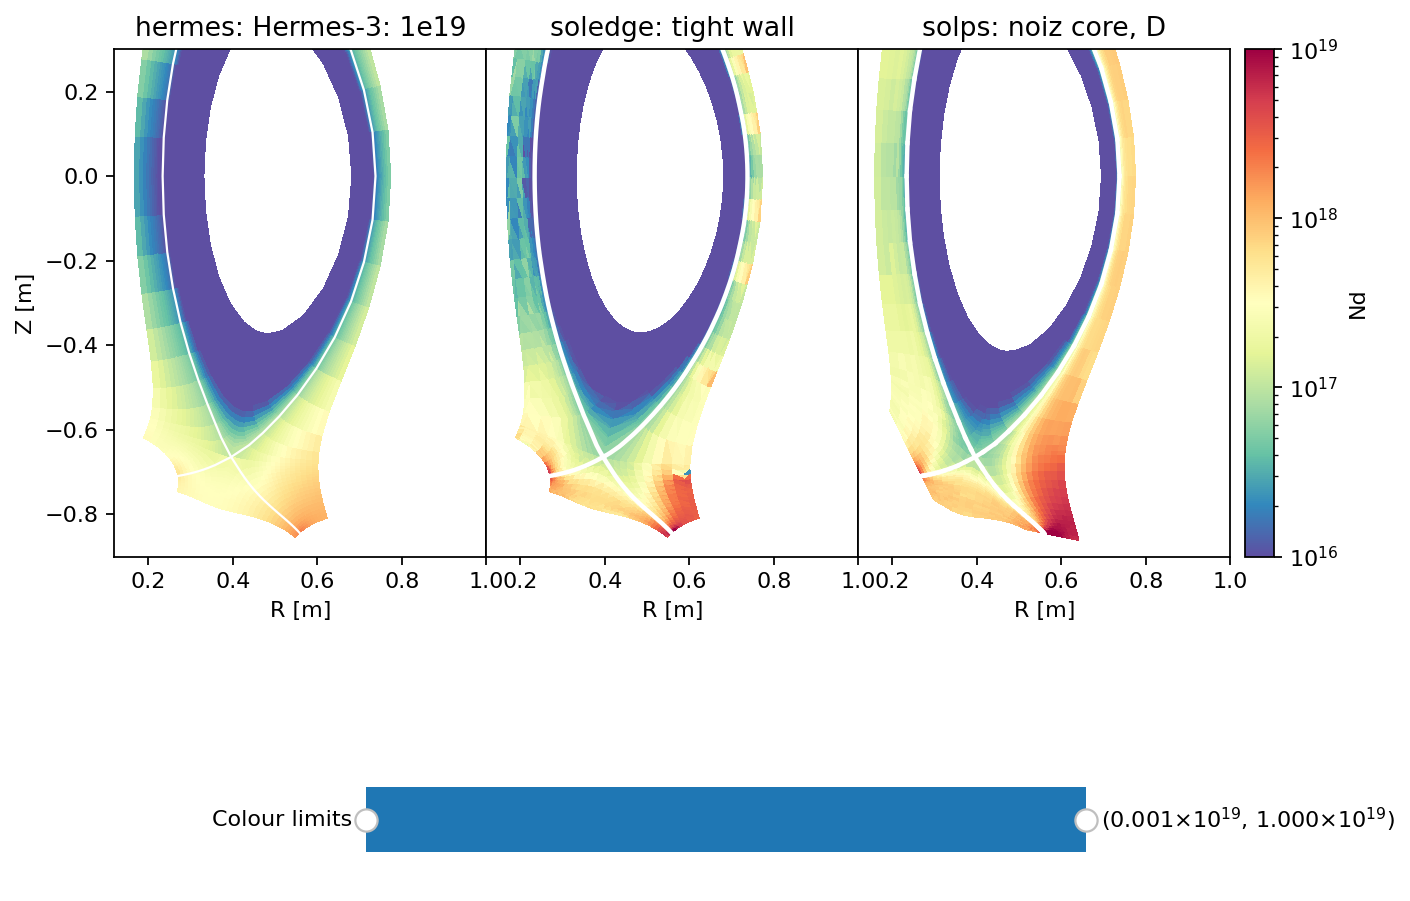

In [28]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "Hermes-3: 1e19", "code" : "hermes", "ds" : casestore["1e19"].ds.isel(t=-1)},
        {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall"]},
        {"name": "noiz core, D", "code":"solps", "path" : solpscases['no_visc']}
    ],
    logscale = True,
    # vmin = 10,
    # vmax = 100,
    vmin = 1e16,
    vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

# Radial flux analysis

## OMP

In [53]:
def makeflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["pf_perp_diff_R_d"] / area_yz
    return hflux

def makehflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["hf_perp_diff_R_d"] / area_yz
    return hflux

omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["rfluxa3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

## IMP

Text(0, 0.5, 'Radial neutral flux [m-2s-1]')

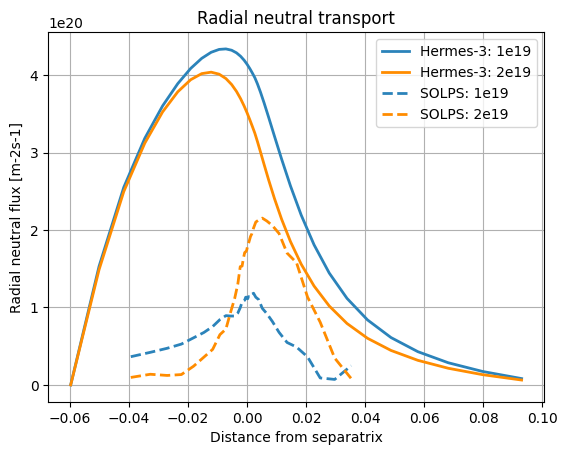

In [19]:
def makeflux(ds):
    imp = ds.hermesm.select_region("inner_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = imp["J"] * imp["g11"]
    hflux = imp["pf_perp_diff_R_d"] / area_yz
    return hflux

def makehflux(ds):
    imp = ds.hermesm.select_region("inner_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = imp["J"] * imp["g11"]
    hflux = imp["hf_perp_diff_R_d"] / area_yz
    return hflux

imp = ds.hermesm.select_region("inner_midplane_a").isel(t=-1, x = slice(2,-2))
dist = imp["R"]-imp["R"][ds.metadata["ixseps1"]]

fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["imp"]["rfluxa3di"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["imp"]["rfluxa3di"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

Text(0, 0.5, 'Radial neutral flux [m-2s-1]')

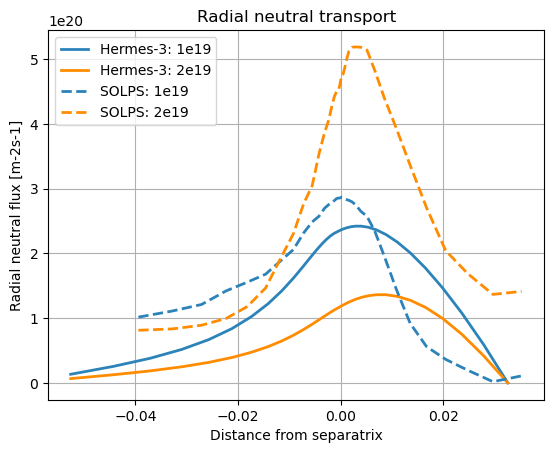

In [46]:
sp["narrow_core"].regions["omp"].keys()

Index(['an3da', 'dn3da', 'dp3da', 'ke3da', 'ki3da', 'mn3da', 'ne3da', 'po3da',
       'te3da', 'ti3da', 'vs3da', 'vx3da', 'vy3da', 'vol3da', 'tie3da',
       'dab23da', 'tab23da', 'dmb23da', 'tmb23da', 'dib23da', 'tib23da',
       'rfluxa3da', 'rfluxm3da', 'pfluxa3da', 'pfluxm3da', 'refluxa3da',
       'refluxm3da', 'pefluxa3da', 'pefluxm3da', 'emiss3da', 'emissmol3da',
       'srcml3da', 'edissml3da', 'pab23da', 'pmb23da', 'pib23da', 'dnb23da',
       'pnb23da', 'tnb23da', 'emisstot3da', 'daeb23da', 'dmeb23da', 'dneb23da',
       'danb23da', 'taib23da', 'tmib23da', 'tnib23da', 'vrab23da', 'vpab23da',
       'vtab23da', 'vrmb23da', 'vpmb23da', 'vtmb23da', 'e0ab23da', 'e0mb23da',
       'eneutrad3da', 'emolrad3da', 'eionrad3da', 'etotrad3da', 'totrad3da',
       'Zeff3da', 'AMJUEL_H.4_2.1.5_3da', 'AMJUEL_H.10_2.1.5_3da',
       'AMJUEL_H.2_3.1.8FJ_3da', 'HYDHEL_H.2_2.2.9_3da',
       'HYDHEL_H.2_2.2.5_3da', 'HYDHEL_H.2_2.2.10_3da', 'AMJUEL_H.0_0.3T_3da',
       'AMJUEL_H.1_0.3T_3da', 'A

Text(0, 0.5, 'Radial neutral flux [m-2s-1]')

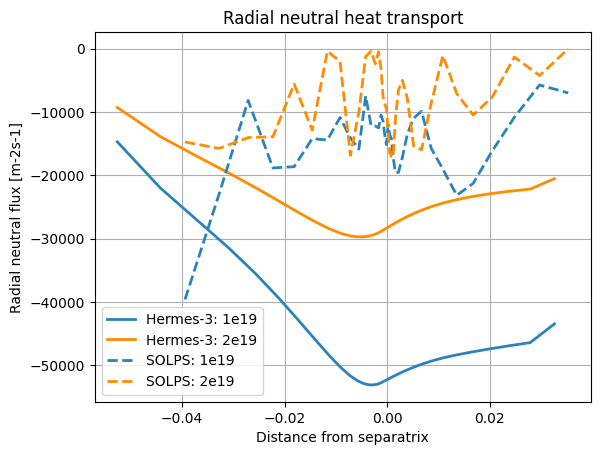

In [54]:
fig, ax = plt.subplots()
ax.plot(dist, -1*(makehflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makehflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral heat transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

Text(0, 0.5, 'Neutral tempearture [eV]')

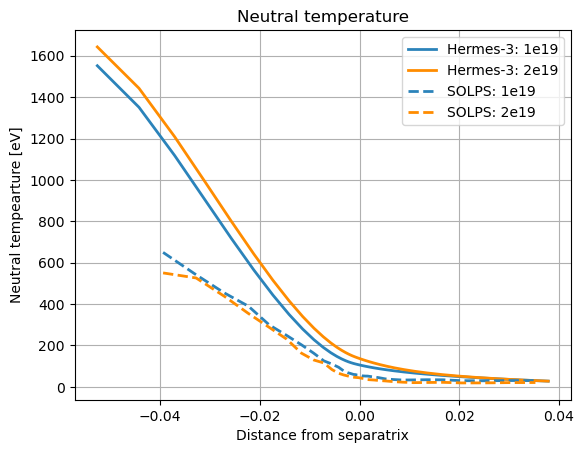

In [72]:
fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    ax.plot(dist, omp["Td"], label = f"Hermes-3: {name}", color = colors[i], lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["tab23da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["tab23da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Neutral temperature")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Neutral tempearture [eV]")

In [30]:
sp["nsep_2e19"].regions["omp"].keys()

Index(['an3da', 'dn3da', 'dp3da', 'ke3da', 'ki3da', 'mn3da', 'ne3da', 'po3da',
       'te3da', 'ti3da', 'vs3da', 'vx3da', 'vy3da', 'vol3da', 'tie3da',
       'dab23da', 'tab23da', 'dmb23da', 'tmb23da', 'dib23da', 'tib23da',
       'rfluxa3da', 'rfluxm3da', 'pfluxa3da', 'pfluxm3da', 'refluxa3da',
       'refluxm3da', 'pefluxa3da', 'pefluxm3da', 'emiss3da', 'emissmol3da',
       'srcml3da', 'edissml3da', 'pab23da', 'pmb23da', 'pib23da', 'dnb23da',
       'pnb23da', 'tnb23da', 'emisstot3da', 'daeb23da', 'dmeb23da', 'dneb23da',
       'danb23da', 'taib23da', 'tmib23da', 'tnib23da', 'vrab23da', 'vpab23da',
       'vtab23da', 'vrmb23da', 'vpmb23da', 'vtmb23da', 'e0ab23da', 'e0mb23da',
       'eneutrad3da', 'emolrad3da', 'eionrad3da', 'etotrad3da', 'totrad3da',
       'Zeff3da', 'AMJUEL_H.4_2.1.5_3da', 'AMJUEL_H.10_2.1.5_3da',
       'AMJUEL_H.2_3.1.8FJ_3da', 'HYDHEL_H.2_2.2.9_3da',
       'HYDHEL_H.2_2.2.5_3da', 'HYDHEL_H.2_2.2.10_3da', 'AMJUEL_H.0_0.3T_3da',
       'AMJUEL_H.1_0.3T_3da', 'A

(200000000000000.0, 9e+17)

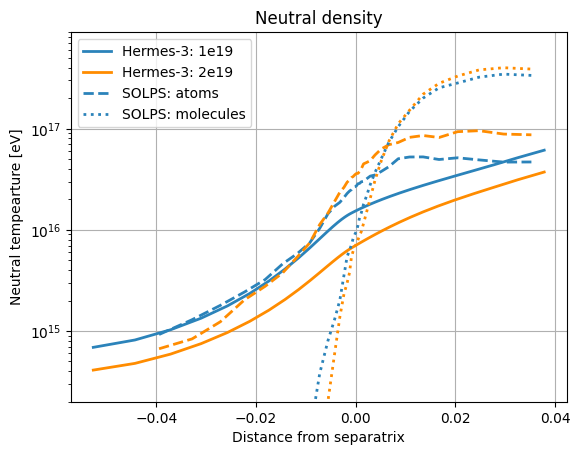

In [40]:
fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    ax.plot(dist, omp["Nd"], label = f"Hermes-3: {name}", color = colors[i], lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["dab23da"], label = "SOLPS: atoms", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["dab23da"],  color = "darkorange", lw=2, ls = "--")

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["dmb23da"], label = "SOLPS: molecules", color = "#2b83ba", lw=2, ls=":")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["dmb23da"], color = "darkorange", lw=2, ls = ":")

ax.legend()
ax.grid()
ax.set_title("Neutral density")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Neutral tempearture [eV]")
ax.set_yscale("log")
ax.set_ylim(2e14,0.9e18)

In [77]:
from sd1d.analysis import AMJUEL

a = AMJUEL()
# rate = a.read_amjuel_2d(path = r"C:\Users\Mike.Kryajak\OneDrive\Project\Atomicrates\H.3 3.1.8.csv")
# cxrate = 

Text(0, 0.5, 'CX rate [s-1m-3]')

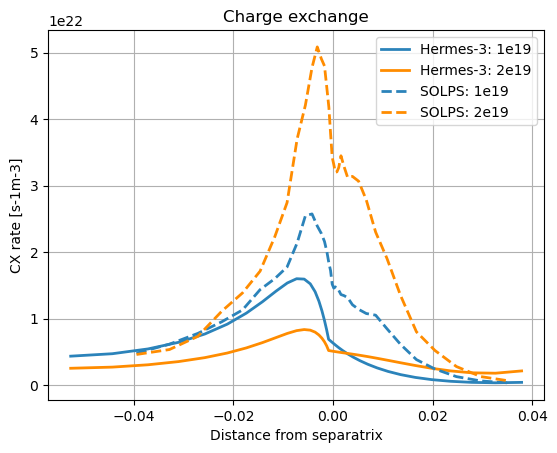

In [89]:
rate = a.amjuel_data["H.2 3.1.8"]
omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, rate, label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Charge exchange")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")


# Ionisation

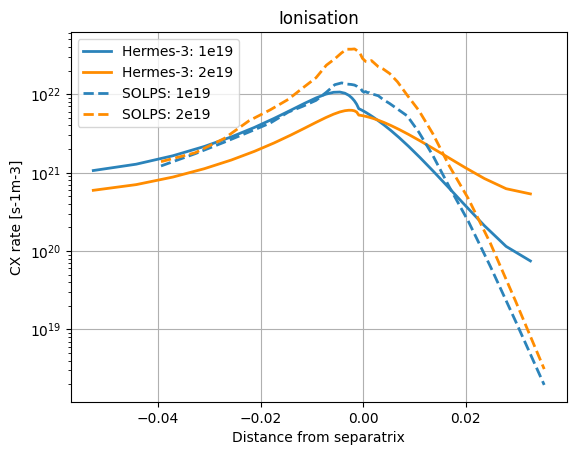

In [10]:
# rate = a.amjuel_data["H.2 3.1.8"]
# omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
# dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

# sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
# rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    # omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    # dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    # sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    # rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, omp["Sd+_iz"], label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.4_2.1.5_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.4_2.1.5_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Ionisation")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")
ax.set_yscale("log")


## IMP

In [15]:
sp["nsep_2e19"].regions["imp"].columns

Index(['an3di', 'dn3di', 'dp3di', 'ke3di', 'ki3di', 'mn3di', 'ne3di', 'po3di',
       'te3di', 'ti3di', 'vs3di', 'vx3di', 'vy3di', 'vol3di', 'tie3di',
       'dab23di', 'tab23di', 'dmb23di', 'tmb23di', 'dib23di', 'tib23di',
       'rfluxa3di', 'rfluxm3di', 'pfluxa3di', 'pfluxm3di', 'refluxa3di',
       'refluxm3di', 'pefluxa3di', 'pefluxm3di', 'emiss3di', 'emissmol3di',
       'srcml3di', 'edissml3di', 'pab23di', 'pmb23di', 'pib23di', 'dnb23di',
       'pnb23di', 'tnb23di', 'emisstot3di', 'daeb23di', 'dmeb23di', 'dneb23di',
       'danb23di', 'taib23di', 'tmib23di', 'tnib23di', 'vrab23di', 'vpab23di',
       'vtab23di', 'vrmb23di', 'vpmb23di', 'vtmb23di', 'e0ab23di', 'e0mb23di',
       'eneutrad3di', 'emolrad3di', 'eionrad3di', 'etotrad3di', 'totrad3di',
       'Zeff3di', 'AMJUEL_H.4_2.1.5_3di', 'AMJUEL_H.10_2.1.5_3di',
       'AMJUEL_H.2_3.1.8FJ_3di', 'HYDHEL_H.2_2.2.9_3di',
       'HYDHEL_H.2_2.2.5_3di', 'HYDHEL_H.2_2.2.10_3di', 'AMJUEL_H.0_0.3T_3di',
       'AMJUEL_H.1_0.3T_3di', 'A

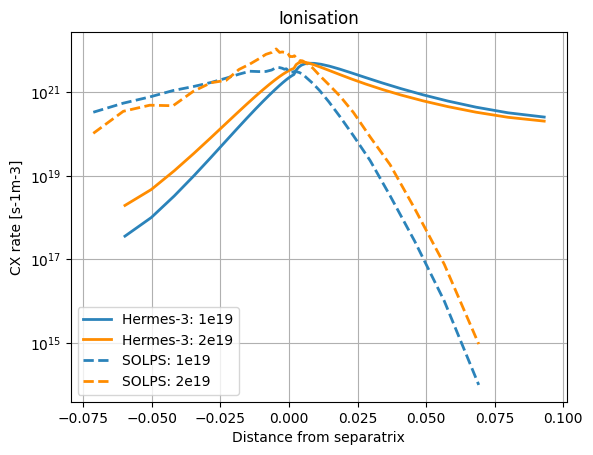

In [17]:
# rate = a.amjuel_data["H.2 3.1.8"]
# omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
# dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

# sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
# rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("inner_midplane_a").isel(t=-1, x = slice(2,-2))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    # omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    # dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    # sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    # rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, omp["Sd+_iz"], label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["imp"].index, sp["narrow_core"].regions["imp"]["AMJUEL_H.4_2.1.5_3di"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["imp"].index, sp["nsep_2e19"].regions["imp"]["AMJUEL_H.4_2.1.5_3di"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Ionisation")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")
ax.set_yscale("log")


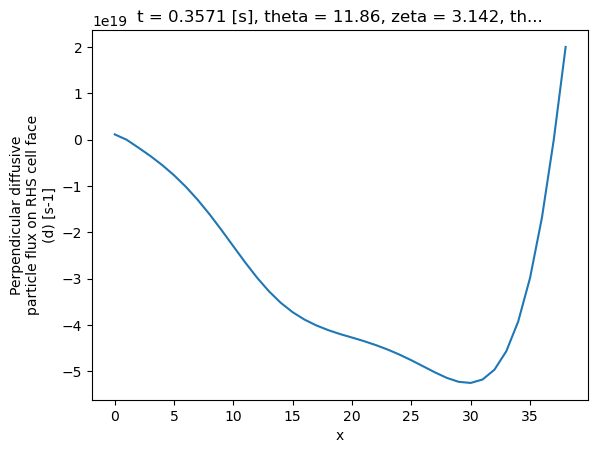

In [26]:
fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    ax.plot(dist, omp["Td"], label = f"Hermes-3: {name}", color = colors[i], lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
# ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["tab23da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["tab23da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Neutral temperature")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Neutral tempearture [eV]")

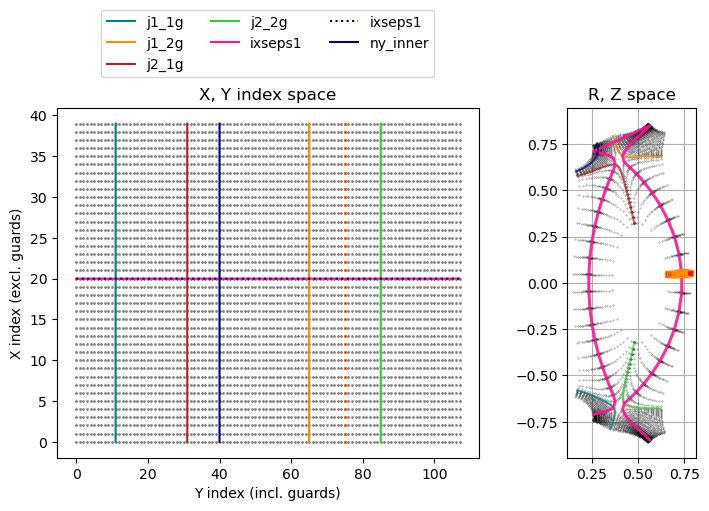

In [24]:
plot_selection(ds, omp)

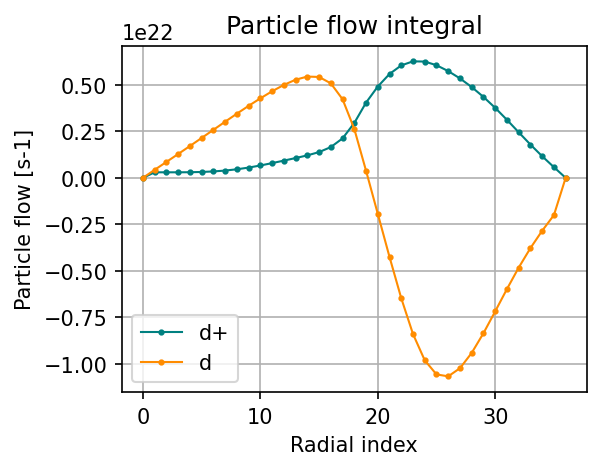

In [16]:
plot_perp_particle_fluxes(ds.isel(t=-1))